## Necessary libraries

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import random
import tensorflow as tf

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

In [59]:
img_path='/content/drive/MyDrive/Data'

covid_imgs = os.listdir('/content/drive/MyDrive/Data/COVID')
normal_imgs = os.listdir('/content/drive/MyDrive/Data/Normal')

covid_paths = [img_path + "/COVID/" + el for el in covid_imgs]
normal_paths = [img_path + "/Normal/" + el for el in normal_imgs]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


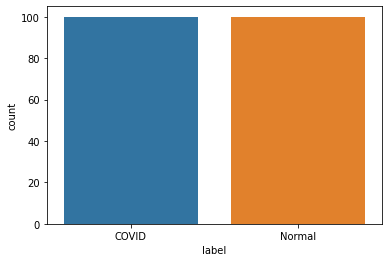

In [60]:
list_files=[]
for dir in os.listdir(img_path):
  directory = os.path.join(img_path,dir)
  
  if os.path.isdir(directory):
    for img in os.listdir(directory):
      list_files.append([os.path.join(dir,img),dir])

df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()
list_files = []

for dir in os.listdir(img_path):
  directory = os.path.join(img_path,dir)

sns.countplot(df.label)
plt.show()

In [61]:
CLASS_NAMES= ['COVID', 'Normal']
IMG_SIZE=224
training_data=[]

def create_training_data():
  for class_name in CLASS_NAMES:
    class_num=CLASS_NAMES.index(class_name)
    path=os.path.join(img_path,class_name)
    for img in os.listdir(path):
      img_array=plt.imread(os.path.join(path,img))
      new_array=np.resize(img_array, (IMG_SIZE,IMG_SIZE))
      training_data.append([new_array,class_num])

create_training_data()

random.shuffle(training_data)

X=[]
y=[]

for features, label in training_data:
  X.append(features)
  y.append(label)

X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y=np.array(y)

X_train, X_rest,y_train, y_rest= train_test_split(X,y,test_size = 0.3)
X_test, X_valid,y_test, y_valid= train_test_split(X_rest, y_rest, test_size=0.33)

## Network Model

In [64]:
i=tf.keras.layers.Input(shape=[224,224,1])
i

<KerasTensor: shape=(None, 224, 224, 1) dtype=float32 (created by layer 'input_3')>

In [65]:
x = tf.keras.layers.Conv2D(32,(3,3), activation = "elu", padding="same")(i)
x=tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(64,(3,3), activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(128,(3,3), activation = "relu",strides=(1,1), padding="valid")(x)
x=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(128,(3,3), activation = "relu",strides=(1,1), padding="valid")(x)
x=tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1,1))(x)
x = tf.keras.layers.Conv2D(128,(3,3), activation = "relu",strides=(1,1), padding="valid")(x)
x=tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x=tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)

In [66]:
model  = tf.keras.Model(i,x)

In [67]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [68]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 53, 53, 128)       7385

In [70]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(140, 224, 224, 1)
(140,)
(20, 224, 224, 1)
(20,)


In [71]:
y_train = np.array(y_train).astype(np.int32)[..., None]
print(y_train.shape)
print(y_train.dtype)

(140, 1)
int32


In [72]:
y_valid = np.array(y_valid).astype(np.int32)[..., None]
print(y_valid.shape)
print(y_valid.dtype)

(20, 1)
int32


## Network learning process

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), batch_size=3, epochs=50, steps_per_epoch=100)

In [ ]:
test_loss,test_acc=model.evaluate(X_test,y_test)

## Results

In [78]:
prediction = model.predict(X_test, batch_size=40)
prediction = np.argmax(prediction, axis=1)
print(classification_report(y_test, prediction, digits = 3))

              precision    recall  f1-score   support

           0      0.944     0.850     0.895        20
           1      0.864     0.950     0.905        20

    accuracy                          0.900        40
   macro avg      0.904     0.900     0.900        40
weighted avg      0.904     0.900     0.900        40



In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
print(cm)

[[17  3]
 [ 1 19]]


Text(0.5, 15.0, 'Predicted label')

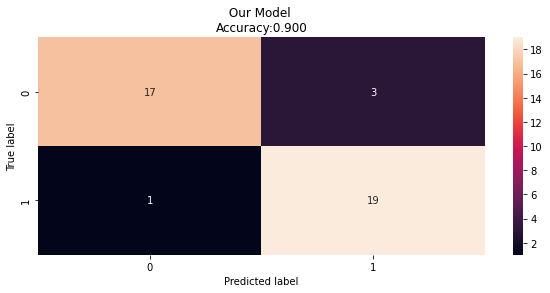

In [80]:
df_cm = pd.DataFrame(cm, index = [i for i in range(0,2)], columns = [i for i in range(0,2)])
plt.figure(figsize=(10,4))
sns.heatmap(df_cm, annot=True)
plt.title(' Our Model  \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, prediction)))
plt.ylabel('True label')
plt.xlabel('Predicted label')